# Building the Data


The Urban Land Expansion dataset leverages combined data from the U.S. Bureau of Economic Analysis (BEA), National Historic Geographic Information System (NHGIS), and compiled land use data from research conducted by He et al..  Gross metropolitan product (GMP) per county was provided through BEA<sup>1,</sup> data, metropolitan statistical boundary (MSA) and population per county were derived from NHGIS<sup>2</sup>.
 
County data was aggregated to the MSA level using the MSA boundaries circa 2018 to maintain a common extent area, allowing us to derive population and GMP per county.  Land use per MSA was then calculated using the data set derived by He et al<sup>3</sup>.  Land use data was available for 2000, 2006, 2010, 2016 so these dates were chosen for the final dataset with 2000 data used as a proxy for 2001 land use.

### Bibliography

1. U.S. Bureau of Economic Analysis. 2020. “BEA : Regional Economic Accounts: Download.” U.S. Bureau of Economic Analysis. July 15, 2020. https://apps.bea.gov/.

1. Manson, Steven, Jonathan Schroeder, David Van Riper, and Steven Ruggles. 2019. “National Historical Geographic Information System: Version 14.0.” Minneapolis, MN: IPUMS. https://doi.org/10.18128/D050.V14.0.

1. He, Chunyang, Zhifeng Liu, Siyuan Gou, Qiaofeng Zhang, Jinshui Zhang, and Linlin Xu. 2019. “Detecting Global Urban Expansion over the Last Three Decades Using a Fully Convolutional Network.” Environmental Research Letters 14 (3): 034008. https://doi.org/10.1088/1748-9326/aaf936.


### Load ULE dataset

In [45]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

If the Dropbox folder is shared and on your C drive, changing user to your username should give file access.

In [2]:
user = 'stevenhall'
os.chdir('C:/Users/' + user + '/Dropbox/Projects/ULE Growth/')
filePath = 'C:/Users/' + user + '/Dropbox/Projects/ULE Growth/'

In [16]:
#load full data from shapefile
gdf = gpd.read_file(filePath + 'Final Dataset/ULE/ULE.shp')
#create a copy with selected variables
ule = gdf[['GEOID','NAME','Year','GMP','Population','Area']].copy()
print(ule.shape)
display(ule.head())
#check for nulls
display('-' *100)
display(ule.isnull().any())

(3459, 6)


,GEOID,NAME,Year,GMP,Population,Area
0,10100,"Aberdeen, SD",2001,3101395.0,81191.0,16.274849
1,10140,"Aberdeen, WA",2001,15379048.0,447025.0,0.936891
2,10180,"Abilene, TX",2001,8064415.0,265524.0,106.347590
3,10220,"Ada, OK",2001,5656851.0,223737.0,5.695775
4,10300,"Adrian, MI",2001,58443937.0,1279512.0,14.633214


'----------------------------------------------------------------------------------------------------'

GEOID         False
NAME          False
Year          False
GMP           False
Population    False
Area          False
dtype: bool

#### Units
GMP is real gross metropolitan product in 2012 chained dollars.  Area is in square kilometers.  

### Apply log transformations

In [18]:
ule['log_GMP'] = np.log(ule['GMP'])
ule['log_Pop'] = np.log(ule['Population'])
ule['log_Area'] = np.absolute(np.log(ule['Area']))
display(ule.head(12))

,GEOID,NAME,Year,GMP,Population,Area,log_GMP,log_Pop,log_Area
0,10100,"Aberdeen, SD",2001,3101395.0,81191.0,16.274849,14.947363,11.304560,2.789621
1,10140,"Aberdeen, WA",2001,15379048.0,447025.0,0.936891,16.548517,13.010370,0.065189
2,10180,"Abilene, TX",2001,8064415.0,265524.0,106.347590,15.902972,12.489461,4.666713
3,10220,"Ada, OK",2001,5656851.0,223737.0,5.695775,15.548378,12.318227,1.739725
4,10300,"Adrian, MI",2001,58443937.0,1279512.0,14.633214,17.883579,14.061989,2.683294
5,10420,"Akron, OH",2001,150430341.0,3295131.0,1144.771046,18.829011,15.007956,7.042960
6,10460,"Alamogordo, NM",2001,33490970.0,1077192.0,22.753505,17.326786,13.889868,3.124719
7,10500,"Albany, GA",2001,12985686.0,389981.0,75.452045,16.379358,12.873853,4.323497
8,10540,"Albany, OR",2001,33683695.0,998650.0,27.671514,17.332524,13.814160,3.320404
9,10580,"Albany-Schenectady-Troy, NY",2001,62859864.0,1456796.0,274.924175,17.956418,14.191750,5.616495


In [20]:
df = ule[['GEOID','log_GMP','log_Pop','log_Area']]
df = df.set_index('GEOID')
display(df)

,log_GMP,log_Pop,log_Area
GEOID,,,
10100,14.947363,11.304560,2.789621
10140,16.548517,13.010370,0.065189
10180,15.902972,12.489461,4.666713
10220,15.548378,12.318227,1.739725
10300,17.883579,14.061989,2.683294
...,...,...,...
49660,18.008125,14.397017,5.863611
49700,18.714822,14.787995,3.614954
49740,19.366088,15.552624,5.207506


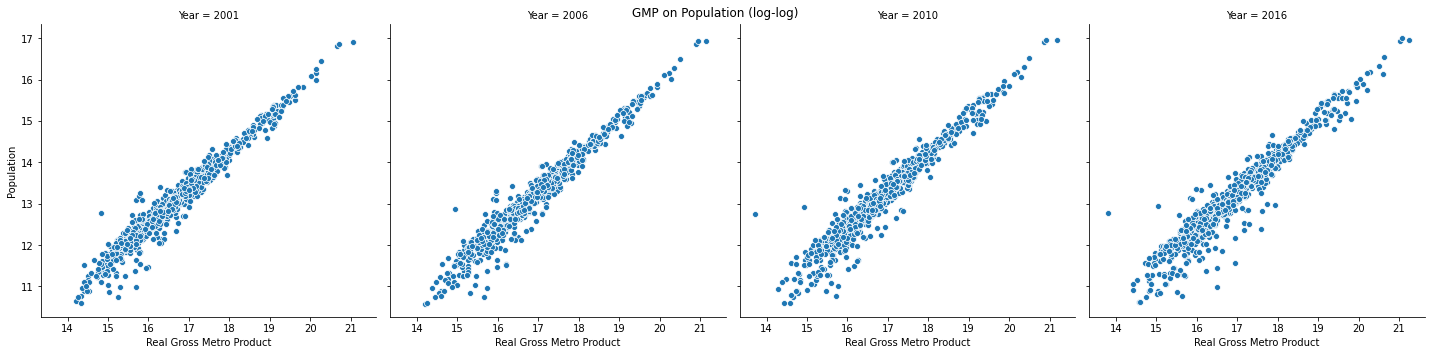

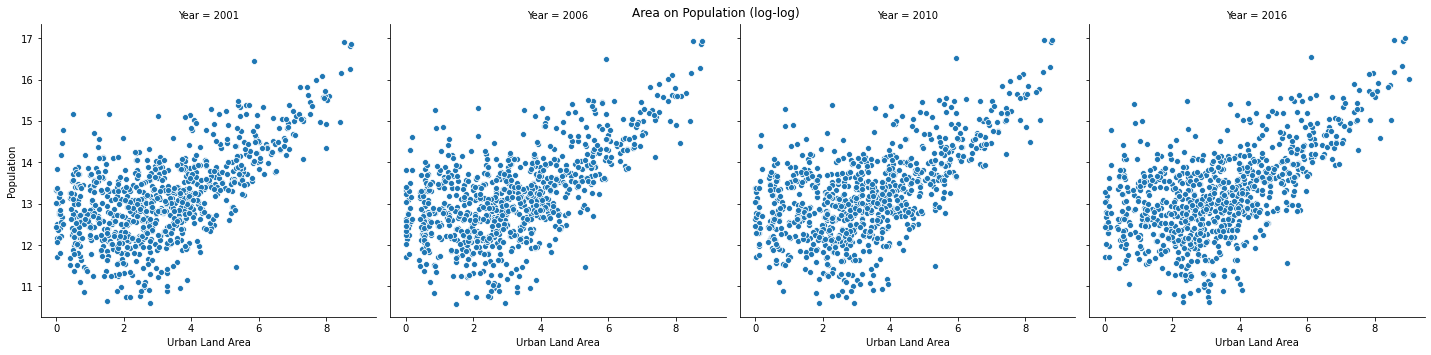

In [23]:
g = sns.relplot(x='log_GMP',y='log_Pop',data=ule,kind='scatter',col='Year')
g.fig.suptitle('GMP on Population (log-log)')
g.set(xlabel='Real Gross Metro Product', ylabel='Population')
p = sns.relplot(x='log_Area',y='log_Pop',data=ule,kind='scatter',col='Year')
p.fig.suptitle('Area on Population (log-log)')
p.set(xlabel='Urban Land Area', ylabel='Population')

## EDA

Begin with regression analysis for subset 2001 data.  

In [29]:
u_01 = ule[ule['Year']==2001]
u_01 = u_01[['GEOID','log_GMP','log_Pop','log_Area']]
u_01 = u_01.set_index('GEOID')
display(u_01)

,log_GMP,log_Pop,log_Area
GEOID,,,
10100,14.947363,11.304560,2.789621
10140,16.548517,13.010370,0.065189
10180,15.902972,12.489461,4.666713
10220,15.548378,12.318227,1.739725
10300,17.883579,14.061989,2.683294
...,...,...,...
49660,17.908535,14.431839,5.679820
49700,18.407486,14.599350,3.472686
49740,19.050012,15.288310,4.576003


### Check for multicolinearity

In [39]:
corr= u_01.corr()
display(corr)

,log_GMP,log_Pop,log_Area
log_GMP,1.000000,0.976733,0.614703
log_Pop,0.976733,1.000000,0.600273
log_Area,0.614703,0.600273,1.000000


In [ ]:
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu')

###  Visualize Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207DCA1FFC8>,
      dtype=object)

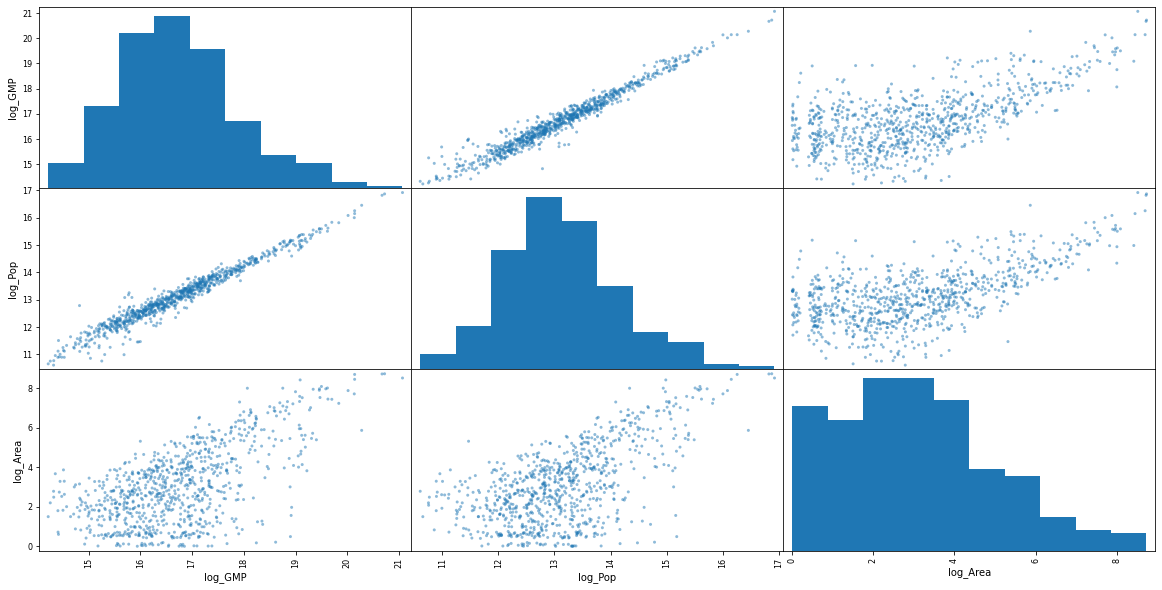

In [38]:
pd.plotting.scatter_matrix(u_01,figsize=(20,10))

In [50]:
u_01_summ = u_01.describe()
u_01_summ.loc['+3_std'] = u_01_summ.loc['mean'] + (u_01_summ.loc['std'] * 3)
u_01_summ.loc['-3_std'] = u_01_summ.loc['mean'] - (u_01_summ.loc['std'] * 3)
display(u_01_summ)

,log_GMP,log_Pop,log_Area
count,857.000000,857.000000,857.000000
mean,16.730879,13.126900,3.064525
std,1.144890,1.034067,1.911872
min,14.218428,10.607525,0.002427
25%,15.914256,12.429936,1.564279
50%,16.652713,13.078136,2.833178
75%,17.346167,13.726245,4.184773
max,21.066126,16.920778,8.730588
+3_std,20.165549,16.229102,8.800141
-3_std,13.296208,10.024697,-2.671092


There do not appear to be any extreme outliers.

## Split to train and test

In [54]:
X = u_01.drop('log_Area',axis=1)
Y = u_01[['log_Area']]

X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=1)

In [56]:
regression_model = LinearRegression()
regression_model.fit(X_train,y_train)

LinearRegression()

In [61]:
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print('The intercept for the 2001 model is {:.4}'.format(intercept))
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for the 2001 model is -13.66
The coefficient for log_GMP is 0.89
The coefficient for log_Pop is 0.14


It is now possible to predict with the model:

In [62]:
y_pred =regression_model.predict(X_test)
y_pred[:5]

array([[2.53406756],
       [2.83429703],
       [3.79584575],
       [1.98082236],
       [2.10930443]])

## Evaluation

Now we test to make certain that:
-  Residuals are normally distributed
-  Residuals are homoscedastic
-  There is no multicollinearity (this one may fail)
-  No autocorrelation

In [64]:
#for simplicity, remodel the data using OLS from statsmodels
X2 = sm.add_constant(X)
model = sm.OLS(Y,X2)
est = model.fit()

### Check for normally distributed residiuals

The mean of the residuals is -1.157e-14


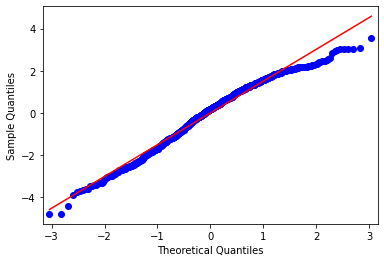

In [70]:
import pylab
sm.qqplot(est.resid, line='s')

mean_residuals = sum(est.resid)/len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

Mean of the residuals is effectively zero.

### Check for heteroscedasticity

In [67]:
# using Breusch-Pagan
_, pval, _, f_pval = diag.het_breuschpagan(est.resid,est.model.exog)
print(pval,f_pval)
print('-'*100)

if pval > 0.05:
    print("For the Breush-Pagan Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypothesis...there is no heteroscedasticity")
    
else:
    print("For the Breush-Pagan Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypothesis...there is heteroscedasticity")

1.1455824164685605e-09 7.399103971415796e-10
----------------------------------------------------------------------------------------------------
For the Breush-Pagan Test
The p-value was 1.146e-09
We reject the null hypothesis...there is heteroscedasticity


### Measures of Error

In [76]:
import math
#calculate mean squared error
model_mse = mean_squared_error(y_test,y_pred)
model_mae = mean_absolute_error(y_test,y_pred)
model_rmse = math.sqrt(model_mse)
model_r2 = r2_score(y_test,y_pred)

print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))
print("R-Squared: {:.2}".format(model_r2))

MSE 2.18
MAE 1.22
RMSE 1.48
R-Squared: 0.4


### Confidence Intervals (95%)

In [77]:
est.conf_int()

,0,1
const,-15.778610,-12.457702
log_GMP,0.618528,1.443535
log_Pop,-0.461845,0.451579


### P-Values

In [78]:
est.pvalues

const      2.493402e-54
log_GMP    1.114200e-06
log_Pop    9.824051e-01
dtype: float64

### Summary

In [79]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Area   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     259.3
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           9.78e-89
Time:                        14:01:11   Log-Likelihood:                -1567.6
No. Observations:                 857   AIC:                             3141.
Df Residuals:                     854   BIC:                             3155.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.1182      0.846    -16.688      0.0

At this point, it looks like the multicollinearity between population and GMP is biasing the results.  